The present program reads the data; calculates many network parameter; tries to generate the equivalent E-R random network using the average degree, sex of the nodes, and number of nodes; and generates the synthetics statistics for the random network for comparison with the real networks.

In [26]:
%matplotlib inline
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import *
import pandas as pd
import os
import networkx as nx
from collections import OrderedDict
from igraph import *

In [27]:
DATA_PATH = 'Data/'

# Global Network Parameters
PARAM_LIST = ['n', 'm', 
             'num_strongly_connected_components', 'size_largest_strongly_connected_components',\
             'num_weakly_connected_components', 'size_weakly_strongly_connected_components',\
             'node_connectivity', 'edge_connectivity', 'avg_clustering', 'transitivity',\
             'avg_distance', 'diameter', 'radius',\
             'density', 'degree_assortativity', 'attribute_assortativity']

# Networks to study
NETWORKS = {'Random': None}

class_ids = sorted([int(file_name.split("_")[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])
for class_id in class_ids:
    NETWORKS['{} w1'.format(class_id)] = None
    NETWORKS['{} w2'.format(class_id)] = None
    


In [28]:
def displayNetwork(network):

    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.tight_layout();
    
    pos = nx.circular_layout(network)
    node_size = [network.in_degree(v)+300 for v in network]
    node_sex = [nx.get_node_attributes(network, 'sex')[v] for v in network]
    node_color = list(map(lambda x: 'red' if x == 'female' else 'blue', node_sex))
    nx.draw_networkx(network, pos, node_size=node_size, 
                     node_color=node_color, alpha=0.9, with_labels=False, 
                     edge_color='.5', cmap=plt.cm.Blues)

def LoadData2Network(file_id, wave_num):

    sex_df        = pd.read_csv(DATA_PATH + "{}_sex.csv".format(file_id), skiprows=0)
    drink_df      = pd.read_csv(DATA_PATH + "{}_drink.csv".format(file_id), skiprows=0)
    drink_df      = drink_df.drop(['drinking w2'], axis=1) if wave_num == 1 else drink_df.drop(['drinking w1'], axis=1)
                    # Select the column of the relevant wave
        
    trust_df = pd.read_csv(DATA_PATH + "{}_trust_w{}.csv".format(file_id, wave_num), index_col=0)
    trust = nx.from_numpy_matrix(trust_df.fillna(0).values, create_using=nx.DiGraph())
    label_mapping = {idx: int(val) for idx, val in enumerate(trust_df.columns)}
    trust_graph = nx.relabel_nodes(trust, label_mapping)
    
    # Set node attributes (sex & drinking frequency)
    for _, row in sex_df.iterrows():
        studentID = row[0]
        sex = row[1]
        trust_graph.node[studentID]['sex'] = 'male' if sex == 1 else 'female'
    
    for _, row in drink_df.iterrows():
        studentID = row[0]
        drink_frequency = row[1]
        trust_graph.node[studentID]['drink'] = drink_frequency
       
    return trust_graph


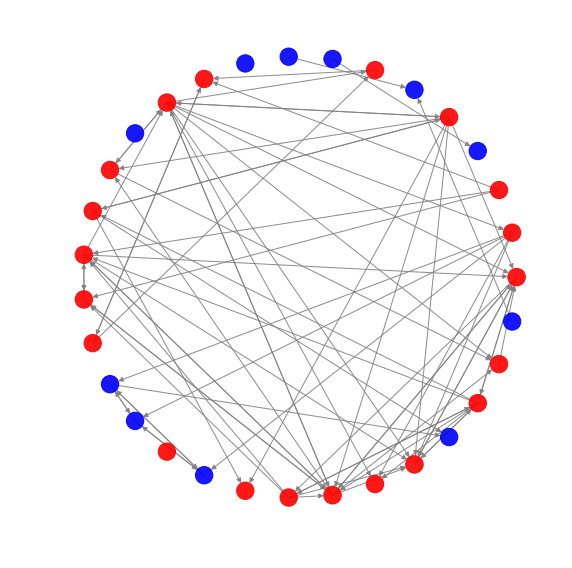

In [29]:
# Sample Network
trust_graph = LoadData2Network(1100, 1)
displayNetwork(trust_graph)

In [30]:
# Auxilary functions
def get_sex_subset(network):
    female = [idx for idx, sex in nx.get_node_attributes(network, 'sex') if sex == 'female']
    male = [idx for idx, sex in nx.get_node_attributes(network, 'sex') if sex == 'male']
    return female, male

def network_as_row(param_dict):
    return pd.DataFrame.from_dict(param_dict, orient='index', columns = PARAM_LIST)
    
def network_as_column(param_dict):
    allnetwork_params = pd.DataFrame.from_dict(param_dict)
    allnetwork_params.index = PARAM_LIST
    return allnetwork_params
    

In [31]:
# Measures for network analysis

def get_network_param(network):
    """
    Measures to study connectivity of the whole network:
        Transitivity, Avg. clustering coefficient, Avg. distance, Diameter, Radius, 
        Number&Size of strongly/weakly connected components, 
        Node connectivity, Edge connectivity,
        Triadic census, Density, Degree assortativity, Attribute assortativity
    """
    
    undirected_network = nx.to_undirected(network)
    
    n = nx.number_of_nodes(network)
    m = nx.number_of_edges(network)
    
    num_strongly_connected_components = nx.number_strongly_connected_components(network)
    size_largest_strongly_connected_components = len(max(nx.strongly_connected_components(network), key=len))
    num_weakly_connected_components = nx.number_weakly_connected_components(network)
    size_weakly_strongly_connected_components = len(max(nx.weakly_connected_components(network), key=len)) 
    node_connectivity = nx.node_connectivity(network)
    edge_connectivity = nx.edge_connectivity(network)
    
    # Params that depend on connectivity of the graph
    avg_clustering = nx.average_clustering(network) if num_strongly_connected_components == 1 else None
    avg_distance = nx.average_shortest_path_length(network) if num_weakly_connected_components == 1 else None
    diameter = nx.diameter(undirected_network) if num_weakly_connected_components == 1 else None
    radius = nx.radius(undirected_network) if num_weakly_connected_components == 1 else None
    
    transitivity = nx.transitivity(network)
    density = nx.density(network)
    degree_assortativity = nx.degree_assortativity_coefficient(network)
    attribute_assortativity = nx.attribute_assortativity_coefficient(network, 'sex')
    
    return [n, m, 
            num_strongly_connected_components, size_largest_strongly_connected_components,
            num_weakly_connected_components, size_weakly_strongly_connected_components,
            node_connectivity, edge_connectivity, avg_clustering, transitivity, avg_distance, diameter, radius, 
            density, degree_assortativity, attribute_assortativity]

def get_node_param(network):
    """
    Measures to study centralization of each node / node importance:
        In/Out-degree centrality, Closeness centrality, 
        Betweenness centrality (in female/male groups), Local clustering coefficient
    * Could consider Eccentricity (-> peripherty nodes & center nodes) in subgraphs if we want
    """
    
    female, male = get_sex_subset(network)
    in_degree_centrality = nx.in_degree_centrality(network)
    out_degree_centrality = nx.out_degree_centrality(network)
    closeness_centrality = nx.closeness_centrality(network)
    betweenness_centrality = nx.betweenness_centrality(network, normalized = True)
    betweenness_centrality_male_to_female = nx.betweenness_centrality(\
                                                    network, male, female, normalized = True)
    betweenness_centrality_female_to_male = nx.betweenness_centrality(\
                                                    network, female, male, normalized = True)
    local_clustering = nx.clustering(network)
    
    return (in_degree_centrality, out_degree_centrality, closeness_centrality, betweenness_centrality,
            betweenness_centrality_male_to_female, betweenness_centrality_female_to_male, local_clustering)

def get_nodepair_param(network):
    """
    To study relations between each pair/triple of nodes:
    """
    similarity_jaccard =getattr(network,"degree")()
    similarity_inverse_log_weighted =getattr(network,"similarity_inverse_log_weighted")(vertices=None, mode=3)
    similarity_dice =getattr(network,"similarity_dice")(vertices=None, pairs=None, mode=3, loops=True)
    tradic_census = nx.triadic_census(network)
    
    return (similarity_jaccard, similarity_inverse_log_weighted, similarity_dice, tradic_census)

def get_network_communities(network):
    """
    IN: Network object
    OUT: Detected communities through different algorithms
    """
    community_infomap = getattr(network,"community_infomap")(edge_weights=None, vertex_weights=None, trials=10)
    community_leading_eigenvector = getattr(network,"community_leading_eigenvector")(clusters=None, weights=None, arpack_options=None)
    community_label_propagation = getattr(network,"community_label_propagation")(weights=None, initial=None, fixed=None)
    community_edge_betweenness = getattr(network,"community_edge_betweenness")( clusters=None, directed=True, weights=None)
    community_spinglass = getattr(network,"community_spinglass")(weights=None, spins=25, parupdate=False, start_temp=1, stop_temp=0.01, cool_fact=0.99, update_rule="config", gamma=1, implementation="orig", lambda_=1)
    community_walktrap = getattr(network,"community_walktrap")(weights=None, steps=4)
    
    return (community_infomap, community_leading_eigenvector, community_label_propagation,
            community_edge_betweenness, community_spinglass, community_walktrap)


In [32]:
# Generates parameter for the synthetic networks
file_ids = [int(file_name.split("_")[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')]
Degree_Collect=[]
Sex_Collect=[]
for file_id in file_ids:
    trust_graph = LoadData2Network(file_id, 1)
    
        
#     degree_Collect.append(degree)
#     sex_Collect.append(sex)

# class_strength= [len(Degree_Collect[i]) for i in range(len(Degree_Collect))]
# mean_degree=[np.sum(Degree_Collect[i])/class_strength[i] for i in range(len(Degree_Collect))]
# p_values=[(mean_degree[i]/class_strength[i]) for i in range(len(mean_degree))]

In [33]:
# # Generates synthetic statistics using the Erdos-Renyi random network
# for n,p,s in zip(class_strength,p_values,Sex_Collect):
#     null_model = Graph.Erdos_Renyi(n,p,directed=True)
#     null_model.vs['sex']=s
#     Degree, Betweenness, Transitivity_avglocal_undirected, Transitivity_undirected,\
#     Transitivity_local_undirected, Transitivity_local_undirected, Diameter, Density, Diversity, Triad_census,\
#     Vertex_connectivity, Similarity_jaccard, Similarity_inverse_log_weighted, Similarity_dice, Assortativity,\
#     Assortativity_degree, Assortativity_nominal,Sex = get_network_param(null_model)

In [34]:
# Gathering the network parameters into a pandas dataframe
for network_name in NETWORKS.keys():
    if network_name == 'Random':
        NETWORKS[network_name] = [None] * len(PARAM_LIST)
        continue
        
    class_id, wave_num = network_name.split(' ')[0], network_name.split(' ')[1]
    trust_graph = LoadData2Network(class_id, 1) if wave_num == 'w1' else LoadData2Network(class_id, 2)
    NETWORKS[network_name] = get_network_param(trust_graph)

allnetwork_params = network_as_row(NETWORKS)
allnetwork_params.to_csv('Network Parameters.csv', sep = '\t', na_rep = 'NaN')

    